In [1]:
%load_ext autoreload
%autoreload 2

import torch
from circuits_benchmark.utils.get_cases import get_cases
import iit.model_pairs as mp
from circuits_benchmark.utils.ll_model_loader.ll_model_loader_factory import get_ll_model_loader
from circuits_benchmark.benchmark.benchmark_case import BenchmarkCase

task_idx = '33'
import os
os.makedirs(f'interp_results/{task_idx}', exist_ok=True)

task: BenchmarkCase = get_cases(indices=[task_idx])[0]

ll_model_loader = get_ll_model_loader(task, interp_bench=True)
hl_ll_corr, model = ll_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')
# turn off grads
# model.eval()
model.requires_grad_(True)

hl_model = task.get_hl_model()
model_pair = mp.StrictIITModelPair(hl_model, model, hl_ll_corr)

{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint()}
dict_keys([TracrHLNode(name: blocks.0.mlp.hook_post,
 label: map_1,
 classes: 0,
 index: [:]
)])


### Run Circuit Discovery

In [2]:
from circuits_benchmark.utils.circuit.circuit_eval import calculate_fpr_and_tpr, build_from_acdc_correspondence
from circuits_benchmark.utils.circuit.circuit import Circuit
from acdc.TLACDCCorrespondence import TLACDCCorrespondence
# from huggingface_hub import hf_hub_download
# import sys
# import pickle
from circuits_benchmark.utils.iit._acdc_utils import get_gt_circuit

# We artificially add the following modules to avoid import errors, since some of the files were pickled before the project was refactored 
# sys.modules["circuits_benchmark.transformers.circuit"] = sys.modules["circuits_benchmark.utils.circuit.circuit"]
# sys.modules["circuits_benchmark.transformers.circuit_node"] = sys.modules["circuits_benchmark.utils.circuit.circuit_node"]

def make_gt_circuit(task: BenchmarkCase):
    hl_ll_corr, model = ll_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')
    full_corr = TLACDCCorrespondence.setup_from_model(model, use_pos_embed=True)
    full_circuit = build_from_acdc_correspondence(corr=full_corr)
    n_heads = model.cfg.n_heads
    return get_gt_circuit(
        hl_ll_corr=hl_ll_corr, 
        full_circuit=full_circuit,
        n_heads=n_heads, 
        case=task)


def get_tpr_fpr_for_circuit(circuit: Circuit, gt_circuit: Circuit):
    full_corr = TLACDCCorrespondence.setup_from_model(model, use_pos_embed=True)
    full_circuit = build_from_acdc_correspondence(corr=full_corr)

    return calculate_fpr_and_tpr(circuit, gt_circuit, full_circuit)


In [3]:
from circuits_benchmark.commands.algorithms.acdc import ACDCRunner, ACDCConfig
from circuits_benchmark.commands.algorithms.eap import EAPRunner, EAPConfig
from circuits_benchmark.commands.algorithms.legacy_acdc import LegacyACDCRunner
def get_acdc_runner(task, threshold, abs_threshold=True):
    config = ACDCConfig(threshold=threshold, abs_value_threshold=abs_threshold)
    acdc_runner = ACDCRunner(task, config=config)
    return acdc_runner

def get_legacy_acdc_runner(task, threshold):
    config = ACDCConfig(threshold=threshold)
    acdc_runner = LegacyACDCRunner(task, config=config)
    return acdc_runner

def get_eap_runner(task, threshold, integrated_grad_steps=10, normalize_scores=False, abs_threshold=True):
    config = EAPConfig(
        threshold=threshold, 
        normalize_scores=normalize_scores,
        integrated_grad_steps=integrated_grad_steps,
        abs_value_threshold=abs_threshold
    )
    eap_runner = EAPRunner(task, config=config)
    return eap_runner


def run(runner, is_categorical: bool, tl_model = model):
    # Prepare data
    data_size = runner.config.data_size
    clean_dataset = task.get_clean_data(max_samples=data_size)
    corrupted_dataset = task.get_corrupted_data(max_samples=data_size)
    clean_inputs, clean_outputs = (
        clean_dataset.get_inputs(),
        clean_dataset.get_targets(),
    )
    corrupted_inputs, corrupted_outputs = (
        corrupted_dataset.get_inputs(),
        corrupted_dataset.get_targets(),
    )
    # if categorical:
    #     clean_outputs = clean_outputs.argmax(dim=-1)
    #     clean_outputs = torch.nn.functional.one_hot(clean_outputs, num_classes=model.cfg.d_vocab_out)[:, 1:, :]
    #     corrupted_outputs = corrupted_outputs.argmax(dim=-1)
    #     corrupted_outputs = torch.nn.functional.one_hot(corrupted_outputs, num_classes=model.cfg.d_vocab_out)[:, 1:, :]
    kwargs = (
        {
            "faithfulness_metric": "mse" if not is_categorical else "kl_div"
        } if isinstance(runner, ACDCRunner) else {}
    )
    circuit = runner.run(
        tl_model=tl_model,
        clean_inputs=clean_inputs,
        clean_outputs=clean_outputs,
        corrupted_inputs=corrupted_inputs,
        corrupted_outputs=corrupted_outputs,
        **kwargs
    )
    return circuit

In [4]:
def run_circuit_discovery_methods(
    runner_classes: list[callable],
    runner_labels: list[str],
    thresholds: list[float],
    task: BenchmarkCase,
    tl_model: torch.nn.Module = model
):
    runner_results = {}
    for t in thresholds:
        runners = [runner_class(threshold=t) for runner_class in runner_classes]
        for runner, label in zip(runners, runner_labels):
            print(f"Running {label} for threshold {t}")
            circuit = run(runner, is_categorical=task.is_categorical(), tl_model=tl_model)
            runner_results.setdefault(label, []).append(circuit)
    return runner_results

In [5]:
%%capture
from functools import partial
thresholds = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 0.025, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 10.0, 20.0, 50.0, 100.0]
# thresholds = sorted(list(set([-t for t in thresholds] + thresholds)))
normalize_scores = False
abs_val_thresholds = True
runner_classes = [
    partial(get_acdc_runner, task=task),
    # partial(get_legacy_acdc_runner, task=task),
    partial(get_eap_runner, task=task, integrated_grad_steps=1, normalize_scores=normalize_scores, abs_threshold=abs_val_thresholds),
    partial(get_eap_runner, task=task, integrated_grad_steps=2, normalize_scores=normalize_scores, abs_threshold=abs_val_thresholds),
    partial(get_eap_runner, task=task, integrated_grad_steps=5, normalize_scores=normalize_scores, abs_threshold=abs_val_thresholds),
    # partial(get_eap_runner, task=task, integrated_grad_steps=10, normalize_scores=normalize_scores),
]
runner_labels = [
    "ACDC",
    # "Legacy ACDC",
    "IG-1 (EAP)",
    # "IG-2",
    "IG-5",
    "IG-10",
]

runner_circuits = run_circuit_discovery_methods(runner_classes, runner_labels, thresholds, task)

### Plot Results

In [6]:
circuit_discovery_results = {}
gt_circuit = make_gt_circuit(task)
for k, results in runner_circuits.items():
    results = [get_tpr_fpr_for_circuit(circuit, gt_circuit) for circuit in results]
    circuit_discovery_results[k] = results


Summary:
 - Nodes TP rate: 1.0
 - Nodes FP rate: 1.0
 - Edges TP rate: 0.5
 - Edges FP rate: 0.7843137254901961

Summary:
 - Nodes TP rate: 1.0
 - Nodes FP rate: 0.8888888888888888
 - Edges TP rate: 0.5
 - Edges FP rate: 0.39215686274509803

Summary:
 - Nodes TP rate: 1.0
 - Nodes FP rate: 0.8888888888888888
 - Edges TP rate: 0.5
 - Edges FP rate: 0.37254901960784315

Summary:
 - Nodes TP rate: 1.0
 - Nodes FP rate: 0.8888888888888888
 - Edges TP rate: 0.5
 - Edges FP rate: 0.4117647058823529

Summary:
 - Nodes TP rate: 1.0
 - Nodes FP rate: 0.8888888888888888
 - Edges TP rate: 0.5
 - Edges FP rate: 0.35294117647058826

Summary:
 - Nodes TP rate: 1.0
 - Nodes FP rate: 0.8888888888888888
 - Edges TP rate: 0.5
 - Edges FP rate: 0.39215686274509803

Summary:
 - Nodes TP rate: 1.0
 - Nodes FP rate: 0.8888888888888888
 - Edges TP rate: 0.5
 - Edges FP rate: 0.37254901960784315

Summary:
 - Nodes TP rate: 1.0
 - Nodes FP rate: 0.8888888888888888
 - Edges TP rate: 0.5
 - Edges FP rate: 0.392

In [7]:
def get_curves(list_of_results: list[list], nodes = True) -> list[tuple[list[float], list[float]]]:
    curves = []
    for results in list_of_results:
        if nodes:
            tprs = [r.nodes.tpr for r in results]
            fprs = [r.nodes.fpr for r in results]
        else:
            tprs = [r.edges.tpr for r in results]
            fprs = [r.edges.fpr for r in results]
        curves.append((fprs, tprs))
    return curves

node_curves = list(get_curves(list(circuit_discovery_results.values()), nodes=True))
edge_curves = list(get_curves(list(circuit_discovery_results.values()), nodes=False))

In [8]:
list(zip(list(zip(list(zip(*node_curves[-1])), list(zip(*edge_curves[-1])))), thresholds))

[(((1.0, 1.0), (1.0, 1.0)), 0.0),
 (((1.0, 1.0), (1.0, 1.0)), 1e-05),
 (((1.0, 1.0), (1.0, 1.0)), 0.0001),
 (((1.0, 1.0), (1.0, 1.0)), 0.001),
 (((1.0, 1.0), (1.0, 1.0)), 0.01),
 (((1.0, 1.0), (0.9411764705882353, 1.0)), 0.025),
 (((1.0, 1.0), (0.8823529411764706, 1.0)), 0.05),
 (((1.0, 1.0), (0.8823529411764706, 1.0)), 0.1),
 (((1.0, 1.0), (0.8823529411764706, 1.0)), 0.2),
 (((1.0, 1.0), (0.6666666666666666, 1.0)), 0.5),
 (((0.8888888888888888, 1.0), (0.49019607843137253, 1.0)), 0.8),
 (((0.8888888888888888, 1.0), (0.49019607843137253, 1.0)), 1.0),
 (((0.8888888888888888, 1.0), (0.45098039215686275, 1.0)), 10.0),
 (((0.5555555555555556, 1.0), (0.27450980392156865, 1.0)), 20.0),
 (((0.5555555555555556, 1.0), (0.1568627450980392, 0.5)), 50.0),
 (((0.1111111111111111, 1.0), (0.0196078431372549, 0.5)), 100.0)]

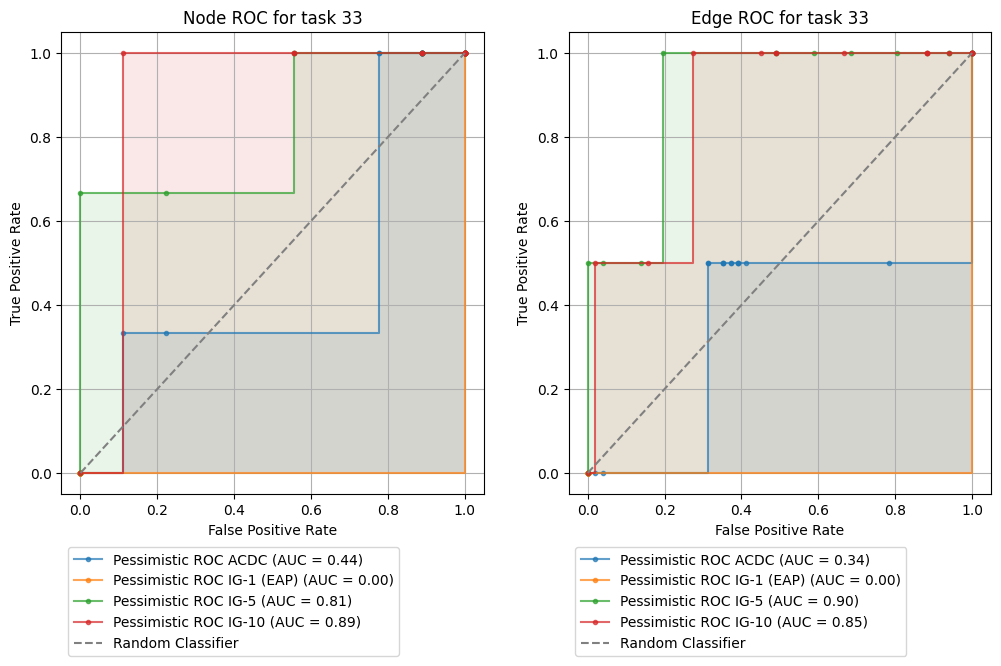

In [9]:
from interp_utils.circuit_discovery.pessimistic_roc import pessimistic_roc
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pessimistic_roc(node_curves, labels=runner_labels, ax=ax[0])
pessimistic_roc(edge_curves, labels=runner_labels, ax=ax[1])
ax[0].set_title(f"Node ROC for task {task_idx}")
ax[1].set_title(f"Edge ROC for task {task_idx}")
# make legend outside of plot
ax[0].legend(loc='upper left', bbox_to_anchor=(0, -0.1))
ax[1].legend(loc='upper left', bbox_to_anchor=(0, -0.1))
fig.savefig(f"interp_results/{task_idx}/roc.pdf", bbox_inches='tight')

In [10]:
def print_result(result, print_attr = 'edges'):
    print(
        f"TPR: {result.__getattribute__(print_attr).tpr}",
        f"FPR: {result.__getattribute__(print_attr).fpr}",
        f"TP: {result.__getattribute__(print_attr).true_positive}",
        f"FN: {result.__getattribute__(print_attr).false_negative}",
        f"FP: {result.__getattribute__(print_attr).false_positive}",
        f"TN: {result.__getattribute__(print_attr).true_negative}",
        sep='\n')

In [11]:
print_result(circuit_discovery_results['IG-1 (EAP)'][0], 'edges')

TPR: 1.0
FPR: 1.0
TP: {(blocks.0.hook_resid_pre, blocks.0.hook_mlp_out), (blocks.0.hook_mlp_out, blocks.1.hook_resid_post)}
FN: set()
FP: {(blocks.0.attn.hook_result[0], blocks.1.attn.hook_result[0]), (blocks.0.hook_mlp_out, blocks.1.attn.hook_result[0]), (blocks.0.hook_resid_pre, blocks.1.attn.hook_result[1]), (blocks.0.attn.hook_result[1], blocks.1.hook_mlp_out), (blocks.0.attn.hook_result[3], blocks.1.hook_mlp_out), (blocks.0.attn.hook_result[1], blocks.1.hook_resid_post), (blocks.0.attn.hook_result[3], blocks.1.hook_resid_post), (blocks.0.attn.hook_result[2], blocks.0.hook_mlp_out), (blocks.0.attn.hook_result[2], blocks.1.attn.hook_result[1]), (blocks.0.attn.hook_result[0], blocks.1.hook_mlp_out), (blocks.0.hook_resid_pre, blocks.1.attn.hook_result[3]), (blocks.0.attn.hook_result[0], blocks.1.hook_resid_post), (blocks.0.hook_mlp_out, blocks.1.hook_mlp_out), (blocks.0.hook_resid_pre, blocks.0.attn.hook_result[2]), (blocks.0.hook_resid_pre, blocks.1.attn.hook_result[2]), (blocks.1.at